# classification

The purpose of this notebook is to assess different classification techniques with the credit card fraud data.

### import dependancies

In [1]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import shap
from time import perf_counter
import xgboost as xgb

### read in data

In [2]:
cc = pd.read_parquet('../data/creditcard2.parquet')

display(cc)

,class,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v23,v24,v25,v26,v27,v28,minute,hour,scaled_amount,scaled_seconds
0,False,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,1.783274,-1.996583
1,False,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,-0.269825,-1.996583
2,False,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,4.983721,-1.996562
3,False,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,1.418291,-1.996562
4,False,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,0.670579,-1.996541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,False,-11.881118,10.071785,-9.834784,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,59,23,-0.296653,1.641931
284803,False,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,59,23,0.038986,1.641952
284804,False,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,59,23,0.641095,1.641974
284805,False,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,59,23,-0.167680,1.641974


## evaluation metrics

The most important piece of information when deciding on evaluation criteria is going to be the massive class imbalance. As stated in the Kaggle description of the dataset itself, the best single metric for evaluating a classifier analyzing a highly imbalanced data set will be the Area Under the Precision-Recall Curve. ROC-AUC, R<sup>2</sup>, F1 score, and most other standard metrics for model evaluation will be less useful here; because if our model was to just spit at a negative class for every element it would still have very high levels of performance by all of these metrics. 

What we really need to emphasize is the Recall (also known as True Positive Rate) of the model. Our goal will be to maximize the true positive results and minimize the false negative. For the sake of making it quantifiable, lets just say that a false negative will cost 4 times as much as a false positive. For these reasons, we will focus on the PR-AUC because it focus on the positive class performance, penalizes false positives and negatives more appropriately, and is less biased towards the majority class. We will still collect and observe and other model metrics, but they will be given very little weight in our overall selection of an ideal model. 

The other major metric I believe is significant here is the execution time of the model. Transactional data sets like these can often be millions of rows and if one model offers a massive increase in compute efficiency, even if it comes at a small loss to model performance, than it may be the most practical overall pick for real world applications. I'm not going to quantify it here, but let's see what we end up with when we make our final consideration and recommendations.

To summarize, model performance will be determine by:
1. PR-AUC, Recall
2. Execution Time
3. ROC-AUC, R<sup>2</sup>, F1 Score, Precision

In [3]:
# create empty data frame to store model results
model_performance_results = pd.DataFrame(columns=['pr_auc', 'recall', 'execution_time', 'roc_auc', 'R_squared', 'f1', 'precision'])

## over-sampling and under-sampling

Now that we have our features selected and refined at an individual field level, let's look at techniques to deal with the massive class imbalance of the data. For this analysis I am going to test 2 different techniques to try and mitigate this issue:

### over-sampling with SMOTE

We are going to sue the python imbalanced-learn library to perform an over-sampling over the dataset. We will be using the Synthetic Minority Over-sampling Technique (SMOTE) to generate more samples of the positive class to use for model training.

### random under-sampling

For our under-sampling method, we are going to equalize the number of positive and negative class elements in our models. To do this we will train our models with all of the positive class data and randomly select and equal number of negative class elements. This will mean throwing out >99% of the data. Normally, that is not something you would want to do. So why do we want to try it? Because it might maximize the performance metrics we actually care about. If the under-sampling ends up having a massively negative impact on our true negative rate, this will become readily apparent in our analysis and we may end up disqualifying this technique from our final model selection.

I am going to go ahead and create all of our training and test sets here, both to improve consistency between models, and because you should never write code twice that can be written once.

In [4]:
# break off target from features
X = cc.drop('class', axis=1).values  # Features
y = cc['class'].values  # Target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# apply SMOTE to over sample
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# apply under-sampling to balance the data
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

### define functions

#### train and test the model

In [5]:
def train_test_model(
    model_name,
    X_train,
    y_train,
    X_test,
    model_function,
    model_parameters={}
):  
    """
    train and test a model using the given training and testing data sets

    Parameters
    ----------
    model_name : str
        The name of the model.
    X_train : pandas.DataFrame    
        The features of the training data set.
    y_train : pandas.Series
        The target values of the training data set.
    X_test : pandas.DataFrame
        The features of the testing data set.
    model_function : function
        The function that initializes the model.
    model_parameters : dict, optional
        The parameters of the model function.
    """
    # save the model name into the results data frame
    model_index = 0
    
    start_time = perf_counter()

    model = model_function(**model_parameters)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    end_time = perf_counter()

    # calculate the exectution time and save to the results data frame
    execution_time = end_time - start_time

    # create output object
    model_output = {
        'model_name': model_name,
        'model': model,
        'model_index': model_index,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'execution_time': execution_time,
    }

    return model_output


#### calculate performance metrics

In [6]:
def calculate_metrics(
    model_output,
    y_test
):
    """
    calculate all relevant model metrics for comparison

    Parameters
    ----------
    model_output : dict
        The output of the model.
    y_test : pandas.Series
        The target values of the testing data set.
    """
    y_pred = model_output['y_pred']
    y_pred_proba = model_output['y_pred_proba']

    pass
    # get the pr-auc score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    # get model recall
    recall = recall_score(y_test, y_pred)
    
    # get roc auc score
    roc_auc = roc_auc_score(y_test, y_pred)

    # get f1 statistic
    f1 = f1_score(y_test, y_pred)

    # get r-squared
    R_squared = accuracy_score(y_test, y_pred)

    # get model precision
    precision = precision_score(y_test, y_pred)

    # create a pandas series to hold the model performance results
    model_metrics = {
        'model_index': model_output['model_name'],
        'model_performance_series': pd.Series({
            'pr_auc': pr_auc,
            'recall': recall,
            'execution_time': model_output['execution_time'],
            'roc_auc': roc_auc,
            'R_squared': R_squared,
            'f1': f1,
            'precision': precision
        })
    }

    return model_metrics

### visualize performance results

In [7]:
def visualize_performance(
    model_output, 
    y_test
):  
    """
    generate Precision-Recall curve and Confusion Matrix plots

    Parameters
    ----------
    model_output : dict
        The output of the model.
    y_test : pandas.Series
        The target values of the testing
    """
    # get recall and precision for prc plot
    y_pred = model_output['y_pred']
    y_pred_proba = model_output['y_pred_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Precision-Recall curve
    axes[0].plot(recall, precision, marker='.')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve')

    # Visualize the confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'], ax=axes[1])
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('Actual Label')
    axes[1].set_title('Confusion Matrix')

    # Adjust layout and add margin between plots
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4) 

    plt.show()

## model testing

The following models have been selected for testing and the criteria for their selection is listed below. The goal here is not so much to be an classifier with perfect performance metrics, but to try a variety of models in order to learn more about the data, and gain insights into what steps we could take next if we wanted to dig deeper.

1. Logistic Regression:

- Simple, Interpretable Model
- Performs Well on Linearly Separable Data
- Handles Imbalanced Datasets

2. Random Forest:

- Non-Linear Model
- Robustness to Imbalanced Data
- Feature Importance
- Reduces Overfitting
- resilient to class imbalance due to its ensembling nature

3. XGBoost (Extreme Gradient Boosting):

- Highly Powerful and Flexible Model
- Handles Imbalanced Data Well
- XGBoost has several techniques to handle imbalanced datasets
- Custom Loss Functions
- Feature Importance and Interpretability
- Regularization: built-in regularization to prevent overfitting, which is critical in imbalanced datasets where overfitting to the majority class is a concern

## logistic regression

simple logistic regression from the sklearn

### train and test model

In [8]:
# test and train with over sampled data
# note: with the over sampled data the max iterations had to be increased for the logistic regression to converge
model_name = "logistic-regression-over"

log_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = LogisticRegression,
    model_parameters={'max_iter': 1000}
)

# print execution time
print("oversampling execution time:  " + str(log_over_output["execution_time"]))

oversampling exeuction time:  8.874734299999545


In [9]:
# logistic regression with under sampled data
# note: under sampled data also required an increase in max iterations for the logistic regression to converge
model_name = "logistic-regression-under"

log_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = LogisticRegression,
    model_parameters={'max_iter': 1000}
)

# print execution time
print("under-sampling execution time: " + str(log_under_output["execution_time"]))

undersampling exeuction time: 0.05650739998964127


### calculate and display model metrics

In [10]:
# calculate the model metrics for the over sampled data
model_metrics = calculate_metrics(
    model_output = log_over_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

# calculate the model metrics for the under sampled data
model_metrics = calculate_metrics(
    model_output = log_under_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
logistic-regression-under,0.725327,0.908163,0.056507,0.935441,0.962624,0.077156,0.040290


### visualize model results

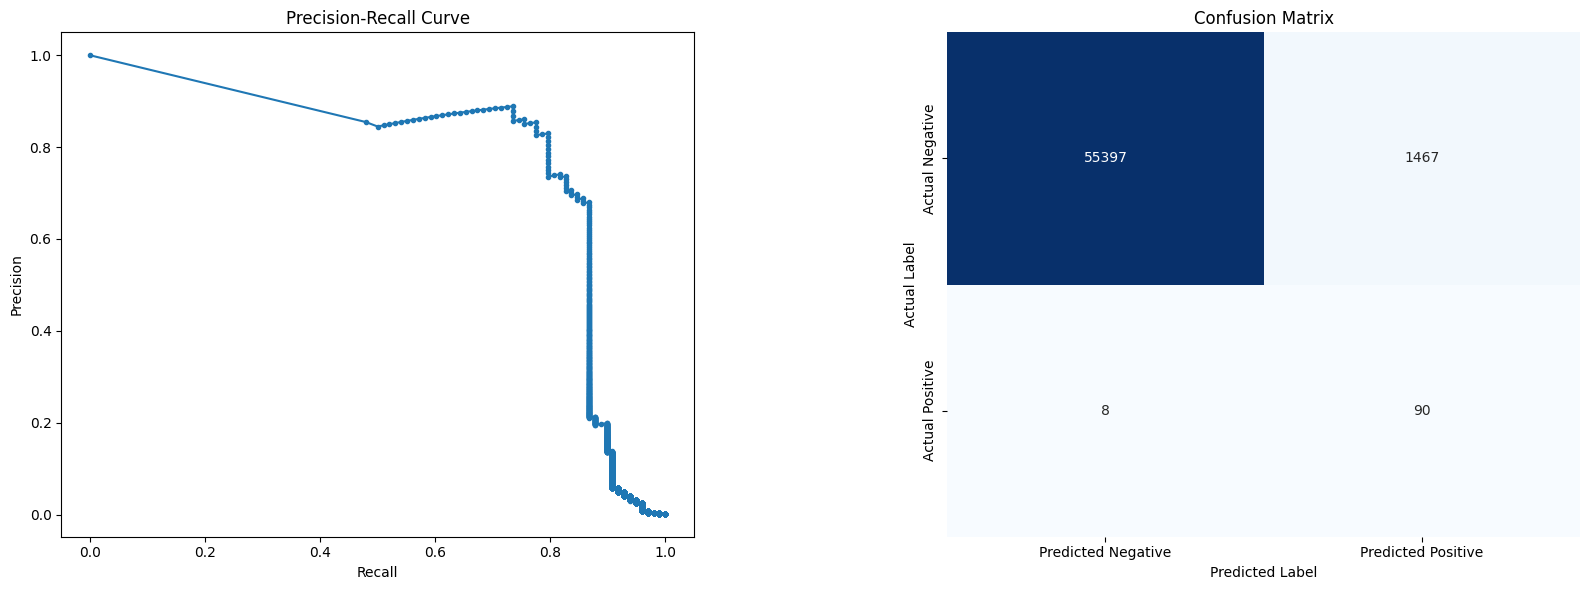

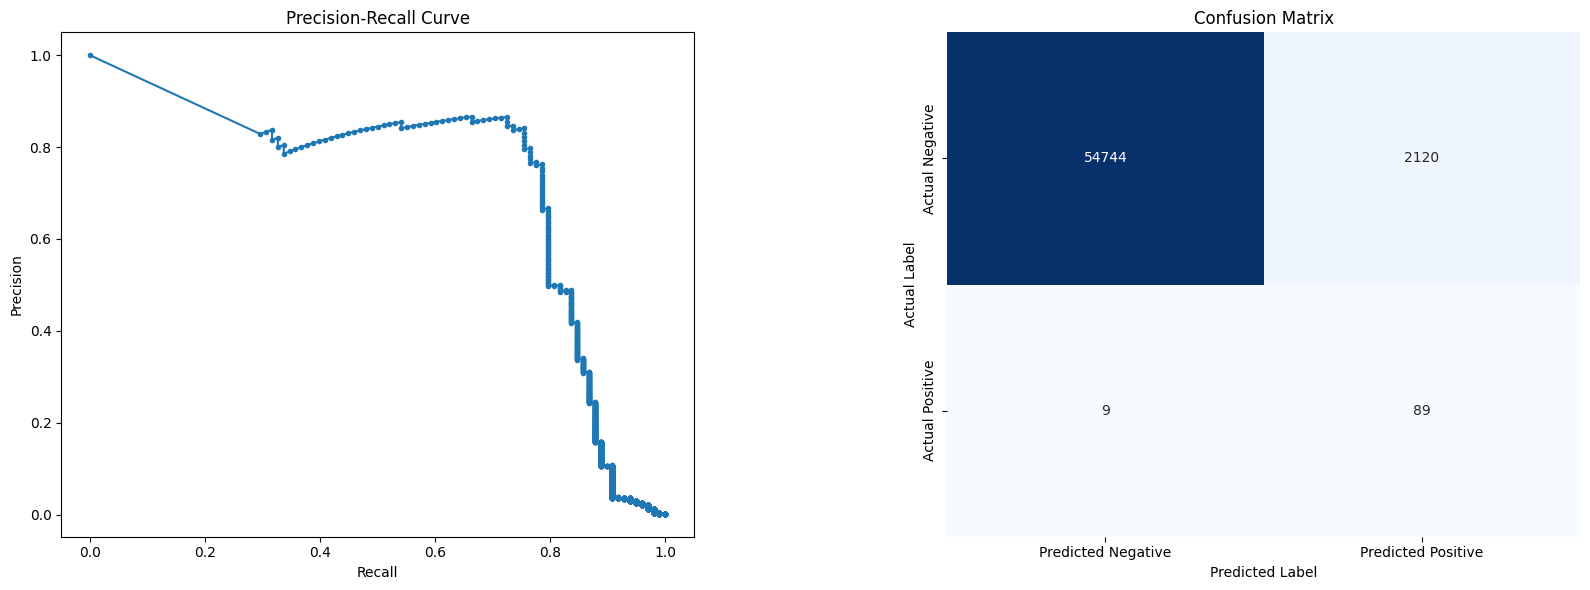

In [11]:
# visualize performance for the over sampled logistic regression
visualize_performance(
    model_output = log_over_output,
    y_test=y_test
)

# visualize performance for the under sampled logistic regression
visualize_performance(
    model_output = log_under_output,
    y_test=y_test
)

## random forest

### train and test model

In [12]:
# random forest with over sampled data
model_name = "random-forest-over"

rf_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = RandomForestClassifier,
    model_parameters={}
)

# print execution time
print("oversampling execution time:  " + str(rf_over_output["execution_time"]))

oversampling exeuction time:  391.3469524999964


In [13]:
# random forest with under sampled data
model_name = "random-forest-under"

rf_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = RandomForestClassifier,
    model_parameters={}
)

# print execution time
print("oversampling execution time:  " + str(rf_under_output["execution_time"]))

oversampling execution time:  0.8181531000009272


### calculate and display model metrics

In [14]:
# calculate the model metrics for the over sampled data
model_metrics = calculate_metrics(
    model_output = rf_over_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

# calculate the model metrics for the under sampled data
model_metrics = calculate_metrics(
    model_output = rf_under_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
logistic-regression-under,0.725327,0.908163,0.056507,0.935441,0.962624,0.077156,0.040290
random-forest-over,0.883881,0.846939,391.346952,0.923381,0.999561,0.869110,0.892473
random-forest-under,0.793760,0.918367,0.818153,0.948404,0.978336,0.127298,0.068389


### visualize model results

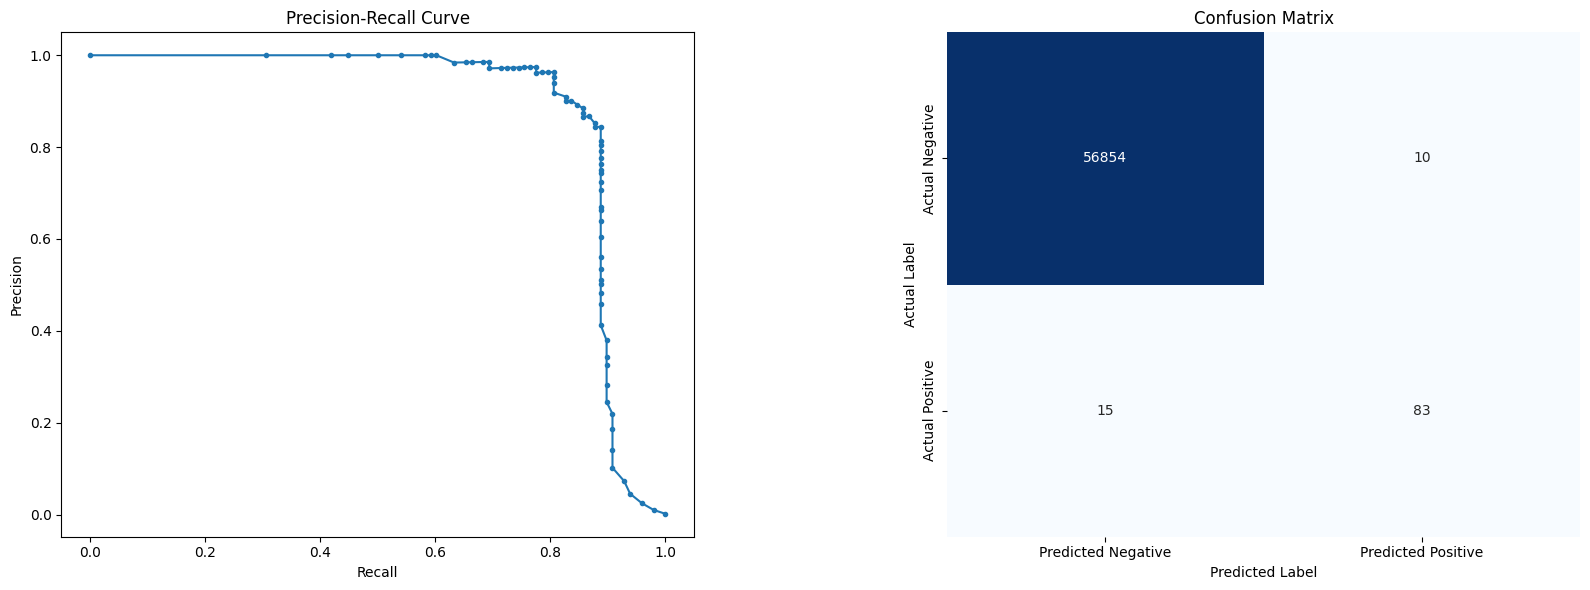

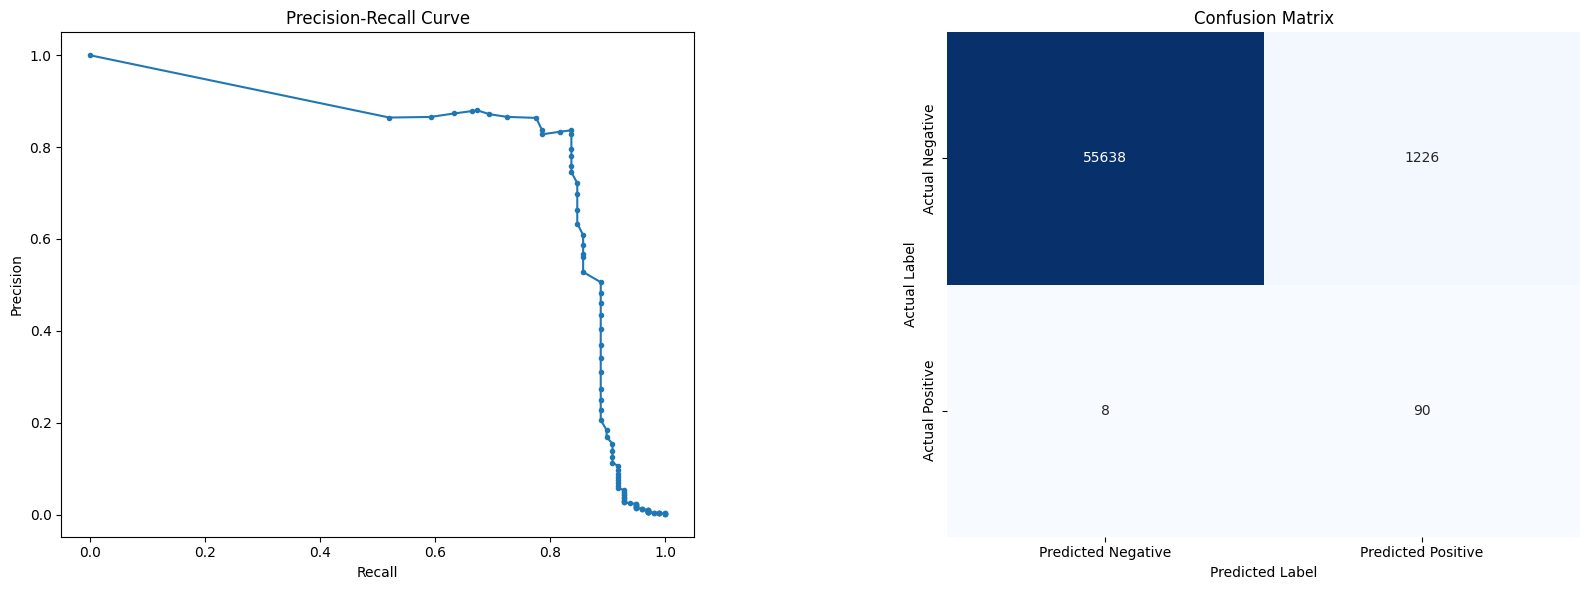

In [15]:
# visualize performance for the over sampled random forest
visualize_performance(
    model_output = rf_over_output,
    y_test=y_test
)

# visualize performance for the under sampled random forest
visualize_performance(
    model_output = rf_under_output,
    y_test=y_test, 
)

## xgboost

### train and test model

In [16]:
# xgboost with over sampled data
model_name = "xgb-over"

xbg_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss'}
)

# print execution time
print("model execution time:  " + str(xbg_over_output["execution_time"]))

model execution time:  2.501333899999736


In [17]:
# xgboost with over sampled data
model_name = "xgb-under"

xbg_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss'}
)

# print execution time
print("model execution time:  " + str(xbg_under_output["execution_time"]))

model execution time:  0.11963410000316799


### calculate and display model metrics

In [18]:
# calculate the model metrics for the over sampled data
model_metrics = calculate_metrics(
    model_output = xbg_over_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

# calculate the model metrics for the under sampled data
model_metrics = calculate_metrics(
    model_output = xbg_under_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
logistic-regression-under,0.725327,0.908163,0.056507,0.935441,0.962624,0.077156,0.040290
random-forest-over,0.883881,0.846939,391.346952,0.923381,0.999561,0.869110,0.892473
random-forest-under,0.793760,0.918367,0.818153,0.948404,0.978336,0.127298,0.068389
xgb-over,0.889723,0.846939,2.501334,0.923294,0.999386,0.825871,0.805825
xgb-under,0.808814,0.948980,0.119634,0.955277,0.961553,0.078283,0.040825


### visualize model results

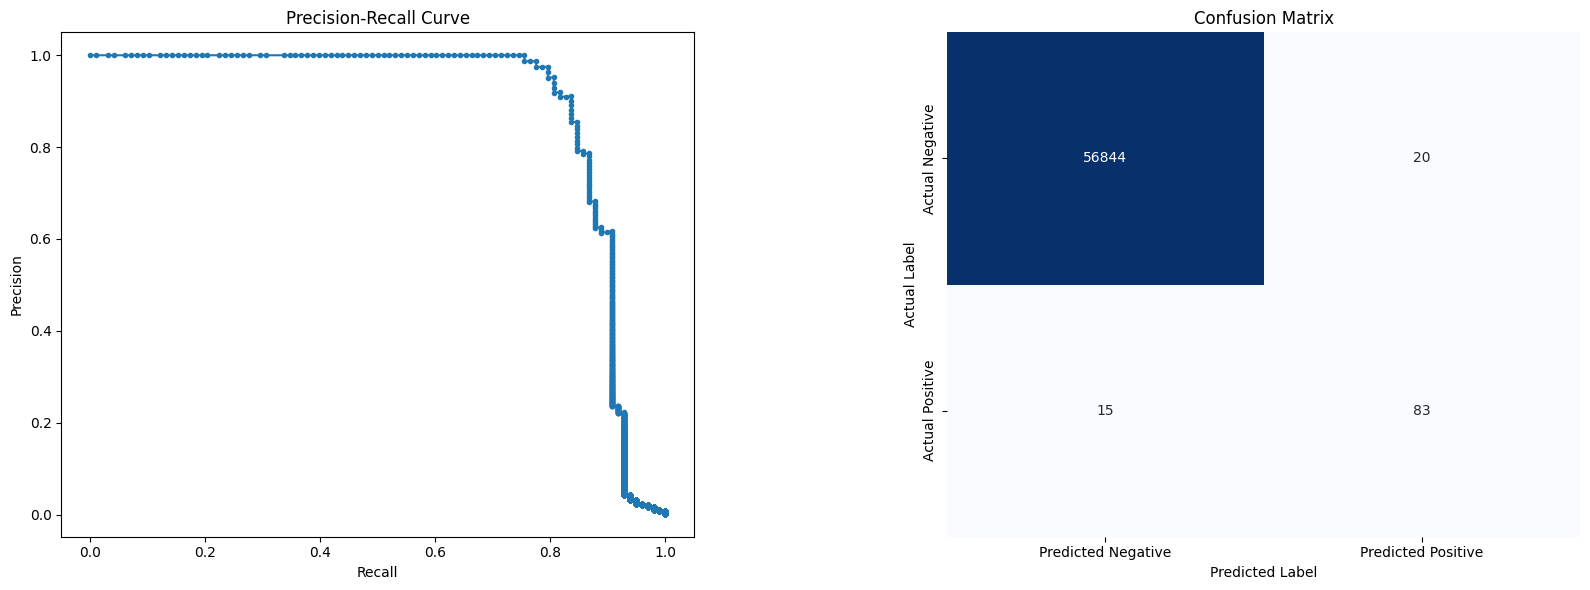

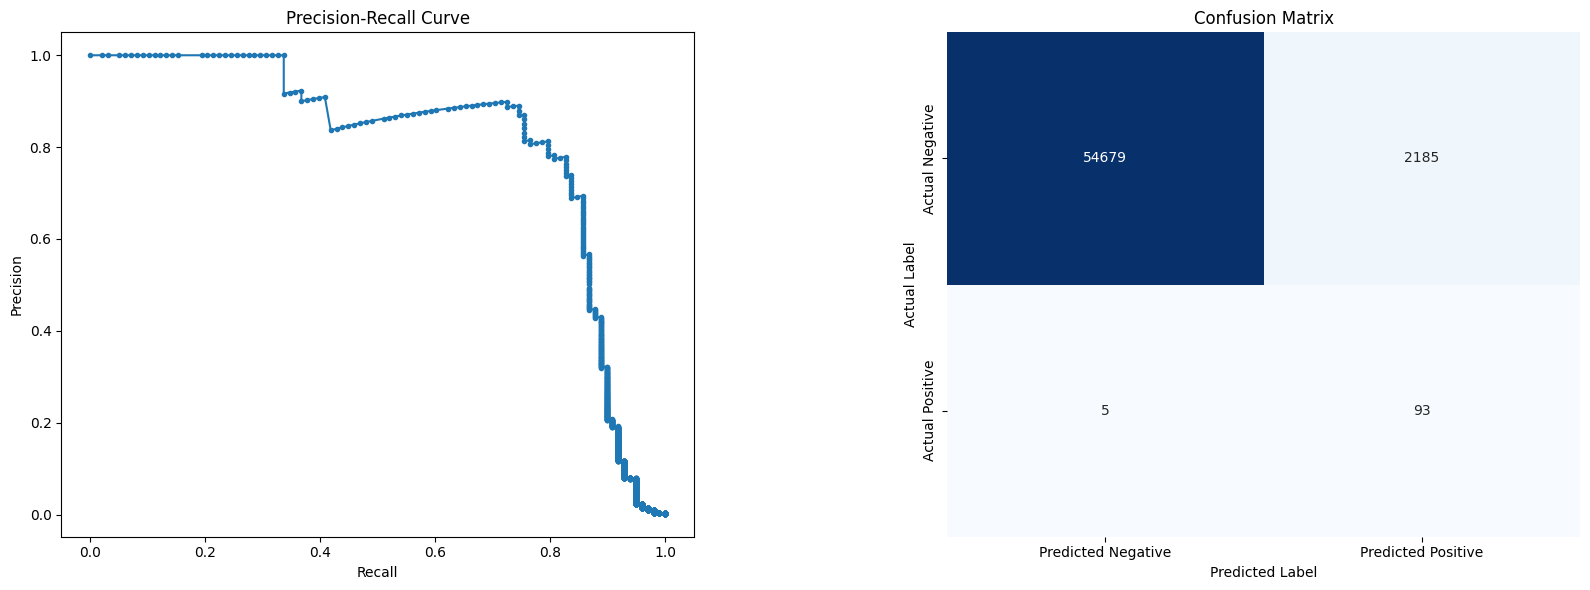

In [19]:
# visualize performance for the over sampled model
visualize_performance(
    model_output = xbg_over_output,
    y_test=y_test
)

# visualize performance for the under sampled model
visualize_performance(
    model_output = xbg_under_output,
    y_test=y_test, 
)

## xgboost with scaled weights

There is one additional option I want to modify here within the xgboost model. The xgboost model specifically offers an argument to scale easily scale the positve weight of the values of the target class. It doesn't really make much sense here to apply this technique to the under-sampled data, but let's just do it here for the sake of consistency.

### train and test model

In [8]:
# Calculate scale_pos_weight
neg_count = sum(y_train_over == 0)
pos_count = sum(y_train_over == 1)
scale_pos_weight = neg_count / pos_count

# train and test with over sampled data
model_name = "xgb-weighted-over"

xbg_weighted_over_output = train_test_model(
    model_name = model_name,
    X_train = X_train_over,
    y_train = y_train_over,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss', 'scale_pos_weight': scale_pos_weight}
)

# print execution time
print("model execution time:  " + str(xbg_weighted_over_output["execution_time"]))

model execution time:  2.632282700011274


In [9]:
# Calculate scale_pos_weight
neg_count = sum(y_train_under == 0)
pos_count = sum(y_train_under == 1)
scale_pos_weight = neg_count / pos_count

# train and test with the under sampled data
model_name = "xgb-weighted-under"

xgb_weighted_under_output = train_test_model(
    model_name = model_name,
    X_train = X_train_under,
    y_train = y_train_under,
    X_test = X_test,
    model_function = xgb.XGBClassifier,
    model_parameters={'eval_metric':'mlogloss', 'scale_pos_weight': scale_pos_weight}
)

# print execution time
print("model execution time:  " + str(xgb_weighted_under_output["execution_time"]))

model execution time:  0.10074209999584127


### calculate and display model metrics

In [22]:
# calculate the model metrics for the over sampled data
model_metrics = calculate_metrics(
    model_output = xbg_weighted_over_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

# calculate the model metrics for the under sampled data
model_metrics = calculate_metrics(
    model_output = xgb_weighted_under_output
    ,y_test = y_test
)

# add the metrics series to the data from at the give model name index
model_performance_results.loc[model_metrics['model_index']] = model_metrics['model_performance_series']

display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
logistic-regression-under,0.725327,0.908163,0.056507,0.935441,0.962624,0.077156,0.040290
random-forest-over,0.883881,0.846939,391.346952,0.923381,0.999561,0.869110,0.892473
random-forest-under,0.793760,0.918367,0.818153,0.948404,0.978336,0.127298,0.068389
xgb-over,0.889723,0.846939,2.501334,0.923294,0.999386,0.825871,0.805825
xgb-under,0.808814,0.948980,0.119634,0.955277,0.961553,0.078283,0.040825
xgb-weighted-over,0.889723,0.846939,2.342683,0.923294,0.999386,0.825871,0.805825
xgb-weighted-under,0.808814,0.948980,0.111964,0.955277,0.961553,0.078283,0.040825


### visualize model results

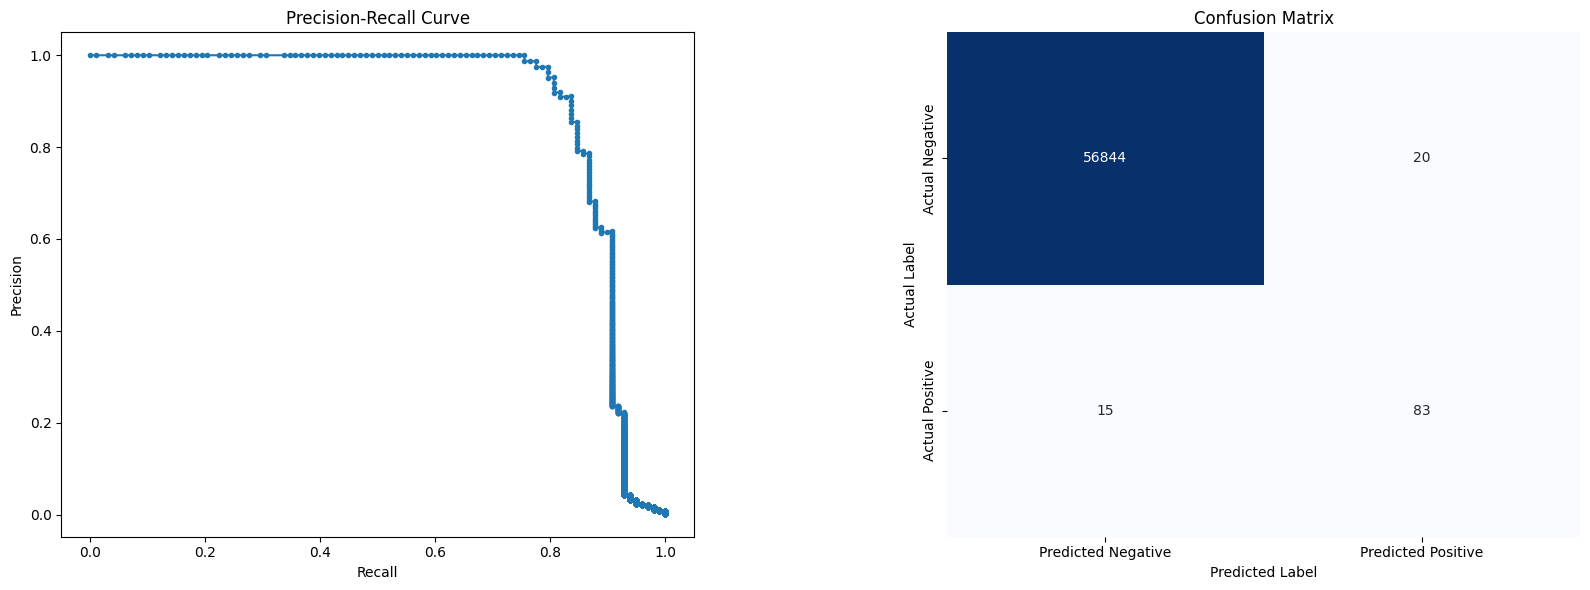

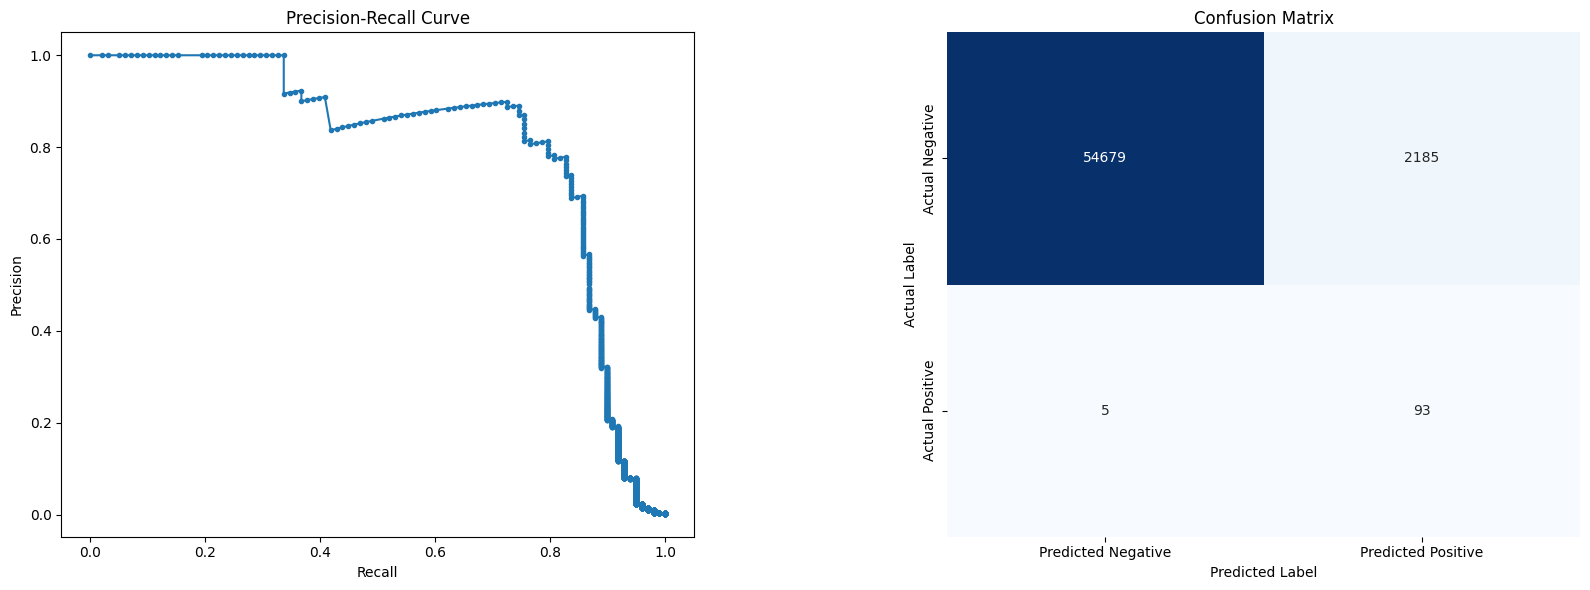

In [23]:
# visualize performance for the over sampled model
visualize_performance(
    model_output = xbg_weighted_over_output,
    y_test=y_test
)

# visualize performance for the under sampled model
visualize_performance(
    model_output = xgb_weighted_under_output,
    y_test=y_test, 
)

## best candidate model

Let's review the final scores.

In [24]:
display(model_performance_results)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
logistic-regression-under,0.725327,0.908163,0.056507,0.935441,0.962624,0.077156,0.040290
random-forest-over,0.883881,0.846939,391.346952,0.923381,0.999561,0.869110,0.892473
random-forest-under,0.793760,0.918367,0.818153,0.948404,0.978336,0.127298,0.068389
xgb-over,0.889723,0.846939,2.501334,0.923294,0.999386,0.825871,0.805825
xgb-under,0.808814,0.948980,0.119634,0.955277,0.961553,0.078283,0.040825
xgb-weighted-over,0.889723,0.846939,2.342683,0.923294,0.999386,0.825871,0.805825
xgb-weighted-under,0.808814,0.948980,0.111964,0.955277,0.961553,0.078283,0.040825


Let's see what stands out just looking at this table. 

Looking at the metrics and the confusion matrices above, we can see that some of the under-sampled data sets produced very low numbers of false negatives. For some of the models the under sampled runs produced superior recall scores. And for all of the under-sampled models produced (not surprisingly) very quick execution times. If avoiding false negatives was truly our goal, then we would probably want to chose one of the under-sampled runs. Also, if we had performance constraints, the under-sampled show honestly pretty amazing performance given that we threw out >99% of the data set. 

However going off of our stated assumption that false negatives are worth 4 times as detrimental as a false positive, the fact that the under sample in most cases increases the number of false positives by at least 100 means these models will not be optimal. The under-sampled models also take a big hit to the PR-AUC stat, and most other model metrics as well.

In [25]:
# remove all under sampled results from the model performance table
model_performance_finalists = model_performance_results[~model_performance_results.index.str.contains("under")]

display(model_performance_finalists)

,pr_auc,recall,execution_time,roc_auc,R_squared,f1,precision
logistic-regression-over,0.778539,0.918367,8.874734,0.946284,0.974106,0.108761,0.057803
random-forest-over,0.883881,0.846939,391.346952,0.923381,0.999561,0.869110,0.892473
xgb-over,0.889723,0.846939,2.501334,0.923294,0.999386,0.825871,0.805825
xgb-weighted-over,0.889723,0.846939,2.342683,0.923294,0.999386,0.825871,0.805825


Now let's visualize our finalists to see who close the results are.

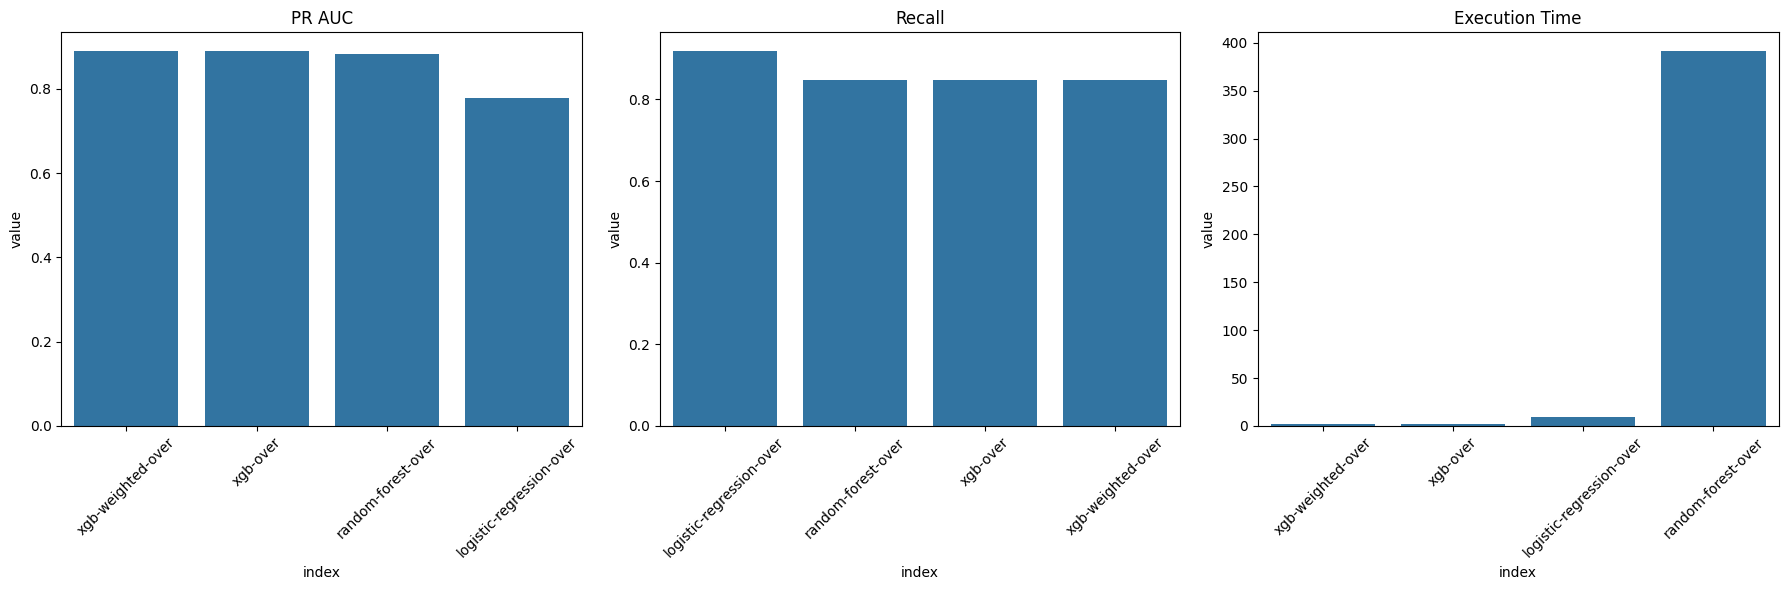

In [26]:
# melt cc to long version with the index as the id_vars and pr_auc and recall as the value_vars
mp_melt_pr_auc = pd.melt(model_performance_finalists.reset_index(), id_vars='index', value_vars=['pr_auc'])
mp_melt_recall = pd.melt(model_performance_finalists.reset_index(), id_vars='index', value_vars=['recall'])
mp_melt_exec_time = pd.melt(model_performance_finalists.reset_index(), id_vars='index', value_vars=['execution_time'])
# sort table by descending value
mp_melt_pr_auc = mp_melt_pr_auc.sort_values('value', ascending=False)
mp_melt_recall = mp_melt_recall.sort_values('value', ascending=False)
mp_melt_exec_time = mp_melt_exec_time.sort_values('value', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot of pr_auc
sns.barplot(data=mp_melt_pr_auc, x='index', y='value', ax=axes[0])
axes[0].set_title('PR AUC')
axes[0].tick_params(axis='x', rotation=45)

# Bar plot of recall
sns.barplot(data=mp_melt_recall, x='index', y='value', ax=axes[1])
axes[1].set_title('Recall')
axes[1].tick_params(axis='x', rotation=45)

# Bar plot of execution time
sns.barplot(data=mp_melt_exec_time, x='index', y='value', ax=axes[2])
axes[2].set_title('Execution Time')
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### conclusion

Our simple logistic regression actually had the highest recall and the lowest number of false negatives. However, it had a very high number of false positive which you can see drag down it's F1 and precision. It also had about 4 times the execution time of the XGBoost models. 

The random forest model comes away with the best overall performance metrics of all of the models compared, however, it has over 100x the execution time of the XGBoost models, and it actually has a marginally lower PR-AUC. 

Looking now at the two XGBoost models, their metrics are virtually identical. The execution time of the over-sampled model with weighted targets actually eeks out the model with unweighted value by just a hair; and that is enough to make it our winner. We this information we have, if I was going to productionalize one of these models, it would the the XGBoost Model that over-sampled with SMOTE and used weighted targets.

## explainability 

Now let's look at which input features have the most impact on our selected model.

### inherent xgboost explainabiltiy metrics

- gain: measures the improvement in accuracy brought by a feature to the branches it is on. It indicates how much each feature improves the model’s accuracy across all splits
- weight: the number of times a feature is used to split the data across all trees. It tells you how often a feature is used
- cover: measures the relative quantity of observations related to a feature. Features with higher coverage contribute more to the prediction

In [10]:
# Get weight, gain, and cover for xbg_weighted_over_output model
weight = xbg_weighted_over_output['model'].get_booster().get_score(importance_type='weight')
gain = xbg_weighted_over_output['model'].get_booster().get_score(importance_type='gain')
cover = xbg_weighted_over_output['model'].get_booster().get_score(importance_type='cover')

# Combine weight, gain, and cover into a DataFrame
weight_df = pd.DataFrame(weight.items(), columns=['feature', 'weight']).sort_values('weight', ascending=False)
gain_df = pd.DataFrame(gain.items(), columns=['feature', 'gain']).sort_values('gain', ascending=False)
cover_df = pd.DataFrame(cover.items(), columns=['feature', 'cover']).sort_values('cover', ascending=False)

# Merge the DataFrames on 'feature' column
df_combined = pd.merge(weight_df, gain_df, on='feature', how='outer')
df_combined = pd.merge(df_combined, cover_df, on='feature', how='outer')

# Extract the original feature names from the dataset
original_feature_names = cc.columns.tolist()

# Create a mapping from XGBoost feature names to original feature names
feature_mapping = {f'f{i}': original_feature_names[i] for i in range(len(original_feature_names))}

# Rename the features in the combined DataFrame using the mapping
df_combined['feature'] = df_combined['feature'].map(feature_mapping)

# Display the combined DataFrame
display(df_combined)

,feature,weight,gain,cover
0,class,106.0,120.554733,1946.726685
1,v1,76.0,89.500488,738.875122
2,v10,111.0,54.341560,2402.357666
3,v11,153.0,161.290176,2331.450684
4,v12,105.0,37.309174,491.778687
5,v13,211.0,4190.593262,5814.259277
6,v14,92.0,71.743423,569.571838
7,v15,90.0,45.076256,1055.329468
8,v16,114.0,89.738815,1478.437622
9,v17,85.0,77.918976,1112.996704


## SHAP values

SHAP values for a model quantify the contribution of each feature to a prediction by comparing the prediction with and without the feature, providing both global and local interpretability based on a game-theoretic approach.

Let's calculate them for our winning model.

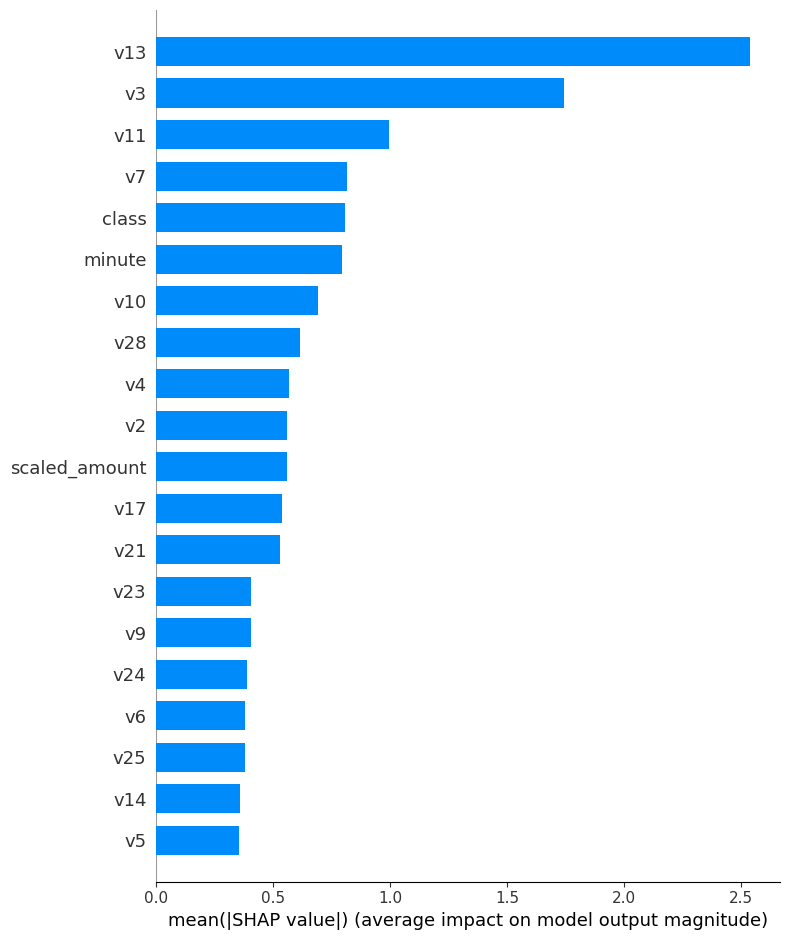

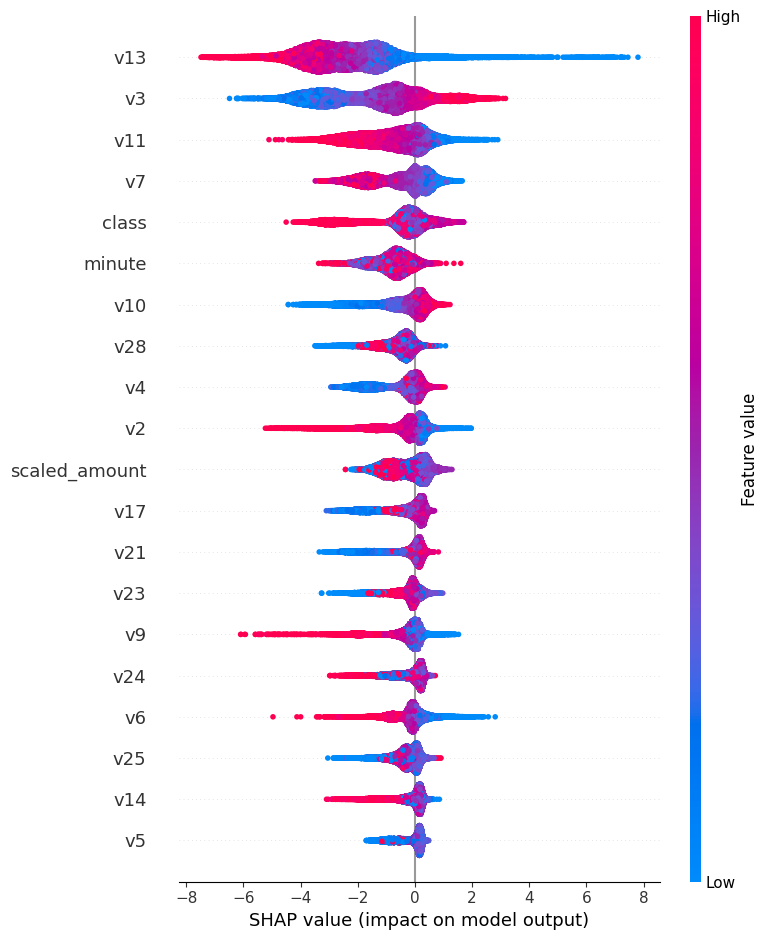

In [19]:
# Create a DMatrix from the X_test data
d_test = xgb.DMatrix(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(xbg_weighted_over_output['model'])

# Get the SHAP values for all the test data
shap_values = explainer.shap_values(d_test)

# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=cc.columns, plot_type='bar')

# print a plot of the shap impact values using sns
shap.summary_plot(shap_values, X_test, feature_names=cc.columns)

## next steps

In this section I am going to address what next steps I would take, if this were a project I was conducted at my own place of work.

### data pre-processing

The first thing I would do if I was with an organization that controlled the raw data, would be to try different steps in the pre-processing the raw data. Steps I would take when working with the raw data would include:

- personally reviewing the quality of the dat
- examining different options for feature generation on the raw data set
- incorporating additional data, potentially including publicly available 3rd party data sets
- trying different dimensionality reduction techniques, specifically UMAP, which I have found to be useful for transactional data in the past

### robustness of model and results

- test other hyperparameters
    - xgboost
        - max_depth
            - limits the depth of each tree, controlling how complex the model can be
        - min_child_weight
            - controls the minimum sum of instance weight (Hessian) needed in a child
        - gamma     
            - controls whether a node will split, based on the reduction of the loss function
    - random forest
        - class_weight
            - adjusts the weights assigned to the minority and majority classes
        - n_estimators
            - controls the number of trees in the forest
        - max_depth
            -  limits the maximum depth of each tree
    - logistic regression
        - class_weight
            - automatically assign weights inversely proportional to the class frequencies
        - solver
            - specifies the optimization algorithm used to fit the logistic regression model
        - penalty
            - specifies the type of regularization to apply

### other models I would like to test

There were additional models I would like to test that are not currently in this project. Including:

- supervised classification methods
    - support vector machines
    - k-nearest neighbor classifier
    - neural networks
        - multi-layer perceptron 
        - convolutional neural network
- anomaly detection models
    - isolation forest
    - one-class SVM
    - autoencoder

### deployment

- deployment of model training
    - convert to proper python script
    - containerize code 
    - connect inputs/outputs to data store
    - parallelize with either cpu or gpu
    - set to run at regular intervals with orchestrator, e.g. airflow
        - redeployment times should be based on how quickly the model is changing and any compute constraints
- deployment of model predictor
    - convert to proper python script
    - containerize code
    - deploy as service
    - connect input/outputs to data store
    - prepare for scaling
        - scaling could be done from 1 VM/EC2/etc. where the code is designed to parallelize within one instance
        - or each instance could resolve 1 prediction and multiple instances spin up/down as needed
    - integrate into service architecture
    - trigger when new data enters environment
        - could be triggered by the completion of another service
        - could be queued as message via AWS SQS/PubSub